In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

In [2]:
path_prefix = '/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''

In [3]:
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur

In [4]:
data_path = path_prefix + "v7/"
pionp_file = ur.open(data_path + "piplus.root")
pp_tree = pionp_file["ClusterTree"]
print(pp_tree)

<TTree b'ClusterTree' at 0x02b568723bb0>


In [5]:
branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
pp = pp_tree.pandas.df(branches, flatten=False)
pp.head()

,clusterIndex,truthE,nCluster,clusterE,clusterECalib,clusterPt,clusterEta,clusterPhi,cluster_nCells,cluster_sumCellE,cluster_ENG_CALIB_TOT,cluster_ENG_CALIB_OUT_T,cluster_ENG_CALIB_DEAD_TOT,cluster_EM_PROBABILITY,cluster_HAD_WEIGHT,cluster_CENTER_MAG,cluster_FIRST_ENG_DENS,cluster_cellE_norm
entry,,,,,,,,,,,,,,,,,,
0,0,1950.726807,3,1706.589233,1847.573242,1393.735718,0.658092,-2.112122,353,1705.227661,1790.404785,7.076038,44.067638,0.018130,1.024731,2423.317871,4.277404e-07,"[0.31853524, 0.0076545365, 0.25650582, 0.02611..."
1,1,1950.726807,3,58.192909,78.681816,46.815140,0.683789,-2.178753,45,54.173908,73.329506,0.755510,11.988488,0.001000,1.191867,3425.696777,1.755061e-10,"[0.027513273, 0.0021719737, 0.0013425057, 0.00..."
2,2,1950.726807,3,0.349190,0.769498,0.315112,0.460979,-2.405282,2,0.285924,0.259033,0.692205,0.078698,0.000623,1.212510,3913.996338,1.603220e-12,"[0.6538643, 0.18118072, 0.16495493]"
3,0,18.619093,2,11.992596,21.729856,11.850097,0.154927,-1.119611,33,11.971533,12.955562,1.463615,2.499960,0.006570,1.167025,2252.051270,8.310836e-10,"[0.16594508, 0.0015814339, 0.05095686, 0.01340..."
4,1,18.619093,2,0.398268,0.827007,0.393829,0.150000,-0.932660,1,0.398268,0.116087,0.330997,0.014711,0.003600,1.109439,3054.038818,5.170689e-12,[1.0]


In [6]:
pp['clusterEoverCalib'] = pp.clusterE / pp.cluster_ENG_CALIB_TOT
pp['clusterEoverTruth'] = pp.clusterE / pp.truthE
pp['cluster_ENG_ALL'] = pp.cluster_ENG_CALIB_TOT + pp.cluster_ENG_CALIB_OUT_T + pp.cluster_ENG_CALIB_DEAD_TOT
# regression variables
pp['logE'] = np.log(pp.clusterE)
pp['logECalib'] = np.log(pp.cluster_ENG_CALIB_TOT)
pp['logECalibAll'] = np.log(pp.cluster_ENG_ALL)

In [7]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler_e = StandardScaler()
scaler_cal = StandardScaler()
scaler_calAll = StandardScaler()
# fit and transform in one step
pp['s_logE'] = scaler_e.fit_transform(pp['logE'].to_numpy().reshape(-1,1))
pp['s_logECalib'] = scaler_cal.fit_transform(pp['logECalib'].to_numpy().reshape(-1,1))
pp['s_logECalibAll'] = scaler_calAll.fit_transform(pp['logECalibAll'].to_numpy().reshape(-1,1))

In [8]:
a = pp['s_logECalib'].to_numpy()
a = a.reshape(1,-1)
a = scaler_cal.inverse_transform(a)

In [9]:
# define convience sub-frames
# train test split
pp['Single'] = pp.nCluster==1 # define a subset of events with only one cluster
mu.splitFrameTVT(pp, trainfrac = 0.5)          # define a train/test fraction of 70/20% (10% for val at this point)

In [10]:
epsilon = 0.000000000001
pp['cluster_fixEM'] = pp.cluster_EM_PROBABILITY.replace(to_replace=0,value=epsilon)
pp['cluster_logEM'] = np.log(pp.cluster_fixEM)
scaler_EM = StandardScaler()
pp['s_logEM'] = scaler_EM.fit_transform(pp.cluster_logEM.to_numpy().reshape(-1,1))
scaler_eta = StandardScaler()
pp['s_eta'] = scaler_eta.fit_transform(pp.clusterEta.to_numpy().reshape(-1,1))
pp['logCenter'] = np.log(pp.cluster_CENTER_MAG)
scaler_center = StandardScaler()
pp['s_logCenter'] = scaler_center.fit_transform(pp.logCenter.to_numpy().reshape(-1,1))
scaler_density = StandardScaler()
pp['s_Density'] = scaler_density.fit_transform(pp.cluster_FIRST_ENG_DENS.to_numpy().reshape(-1,1))

In [11]:
EMB1_cells = mu.setupCells(pp_tree, 'EMB1') # implicitly flatten
EMB2_cells = mu.setupCells(pp_tree, 'EMB2')
EMB3_cells = mu.setupCells(pp_tree, 'EMB3') # implicitly flatten

TileBar0_cells = mu.setupCells(pp_tree, 'TileBar0') # implicitly flatten
TileBar1_cells = mu.setupCells(pp_tree, 'TileBar1') # implicitly flatten
TileBar2_cells = mu.setupCells(pp_tree, 'TileBar2') # implicitly flatten

In [12]:
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.keras as keras
from tensorflow.keras.models import load_model

In [13]:
import tensorflow as tf
import tensorflow_probability as tfp

strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [14]:
combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
All_input = np.column_stack((pp['s_logE'],pp['s_eta'],s_All_cells))

In [15]:
import scipy.stats as stats
# from . import plot_util as pu
from util import plot_util as pu


def _q16(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    return np.percentile(x, 16)

def _q84(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    return np.percentile(x, 84)

def responsePlot(x, y, figfile='', statistic='median',
                 xlabel='True Energy [GeV]', ylabel='Predicted Energy / True Energy',
                 xlim=(0.3,1000), ylim=(0,3), baseline=True,
                 atlas_x=-1, atlas_y=-1, simulation=False,
                 textlist=[]):
    xbin = [10**exp for exp in np.arange(-1.0, 3.1, 0.1)]
    ybin = np.arange(0., 3.1, 0.1)
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
    
    responseMed = stats.binned_statistic(x, y, bins=xbin, statistic=statistic).statistic
    responseQ16 = stats.binned_statistic(x, y, bins=xbin, statistic=_q16).statistic
    responseQ84 = stats.binned_statistic(x, y, bins=xbin, statistic=_q84).statistic

    responseQ16 = responseMed - responseQ16
    responseQ84 = responseQ84 - responseMed

    plt.cla()
    plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1)
    plt.errorbar(xcenter, responseMed, yerr=[responseQ16,responseQ84], color='red')
    if baseline:
        plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black')
    plt.xscale('log')
    plt.ylim(ylim)
    plt.xlim(xlim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)
    # ampl.set_zlabel('Clusters')
    cb = plt.colorbar()
    cb.ax.set_ylabel('Clusters')
    # plt.legend()

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, responseMed


def _iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q16, q84 = np.percentile(x, [16, 84])
    return (q84 - q16) / (2 * np.median(x))


def resolutionPlot(x, y, figfile='',
                   xlabel='True Energy [GeV]', ylabel='Response IQR / (2 x Median)',
                   atlas_x=-1, atlas_y=-1, simulation=False,
                   xlim=(0.3,1000), ylim=(0,1), 
                   textlist=[]):
    xbin = [10**exp for exp in  np.arange(-1.0, 3.1, 0.1)]
    xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]

    resolution = stats.binned_statistic(x, y, bins=xbin, statistic=_iqrOverMed).statistic
    
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(xcenter, resolution)
    plt.xscale('log')
    plt.xlim(xlim)
    plt.ylim(ylim)
    pu.ampl.set_xlabel(xlabel)
    pu.ampl.set_ylabel(ylabel)

    pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

    if figfile != '':
        plt.savefig(figfile)
    plt.show()

    return xcenter, resolution


def histogramSlices(x, ylist, labels=[''], xstep=0.2, statistic='iqr', title = 'Response',
                 xlabel='Predicted Energy / True Energy', ylabel='Clusters', alpha=1.,
                 xlim=(0.3,1000.), ylim=(0.,3.1), binsize=0.05, baseline=False, logscale=False, density=False,
                 atlas_x=-1, atlas_y=-1, simulation=False,
                 textlist=[]):
    
    if type(ylist) != type([]):
        ylist = [ylist]

    xbin = [10**exp for exp in np.arange(-1.0, 3.1, xstep)]
    last_xbin = [10**exp for exp in np.arange(-1.0, 3.1, xstep)]
    
    ybin = np.arange(ylim[0], ylim[1], binsize)

    plt.cla()
    plt.clf()

    for xbin_left,xbin_right in zip(last_xbin,xbin[1:]):
        fig = plt.figure()
        val_mask = np.logical_and(x > xbin_left, x < xbin_right)

        for y,label in zip(ylist,labels):
            if statistic == 'iqr':
                med = np.median(y[val_mask])
                iqr = np.percentile(y[val_mask], q=84) - np.percentile(y[val_mask], q=16)
                plt.hist(y[val_mask], bins=ybin, density=density, 
                        label = label + ' Median = {:.2f}, IQR = {:.2f}'.format(med, iqr),
                         alpha=alpha)
            elif statistic == 'std':
                mu = np.mean(y[val_mask])
                sig = np.std(y[val_mask])
                plt.hist(y[val_mask], bins=ybin, density=density, 
                        label = label + ' Mean = {:.2f}, Std. Dev. = {:.2f}'.format(mu, sig),
                         alpha=alpha)
            else:
                plt.hist(y[val_mask], bins=ybin, density=density,
                         label = label,
                         alpha=alpha)
            
            if baseline:
                x1 = np.linspace(-6,6,100)
                pdf = stats.norm.pdf(x1)
                plt.plot(x1, pdf, label='Unit Normal')

        if len(textlist) >= 2:
            textlist[1]['text'] = '{:.4g} - {:.4g} GeV Clusters'.format(xbin_left, xbin_right)
            pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

        if logscale:
            plt.yscale('log')

        # plt.title(title + ' {:.4g} - {:.4g} GeV'.format(xbin_left, xbin_right))
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xlim(ylim)
        plt.legend()
        plt.show()

In [16]:
def mdn_cust():
    KMIX = 3  # KMIX is the number of mixtures
    NOUT = KMIX * 3          # number of pct, mu, std
    number_pixels = 512 + 256 + 128 + 16 + 16 + 8 + 2


    input = Input(shape=(number_pixels))
    hidden_0 = Dense(number_pixels,activation='relu')(input)
    hidden_1 = Dense(number_pixels,activation='relu')(hidden_0)
    hidden_2 = Dense(number_pixels/2,activation='relu')(hidden_1)
    a = Dense(KMIX,activation='softmax',name='a')(hidden_2)
    mu = Dense(KMIX,activation='relu',name='mu')(hidden_2)
    sigma = Dense(KMIX,activation='elu',name='sig')(hidden_2)
    Output = keras.layers.Concatenate()([a,mu,sigma])
    model = keras.Model(input,Output)
    opt = Adam(learning_rate=1e-4)#, decay=1e-6)
    lost_fn = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
    model.compile(optimizer=opt, loss=lost_fn)
    return model

In [17]:
def eval_generator(data, batch_size):
     batches = (len(data) + batch_size - 1)//batch_size
     for i in range(batches):
          X = data[i*batch_size : (i+1)*batch_size]
          yield (X)

In [18]:
def convert_to_tensor(X):
    return tf.concat([tfp.distributions.Distribution.mean(X), tfp.distributions.Distribution.stddev(X)],1)

In [19]:
def MDN_3():
    event_shape = [1]
    num_components = 5
    params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
    number_pixels = 512 + 256 + 128 + 16 + 16 + 8 
    model = Sequential()
    features = number_pixels + 2
    model.add(Dense(features, input_dim=features, kernel_initializer='normal', activation='relu'))
    
    model.add(Dense(features, activation='relu'))
    model.add(Dense(int(features/2), activation='relu'))
    model.add(Dense(units=params_size, activation=lambda x: tf.clip_by_value(x, -30., 30.)))
    
    # model.add(tfp.layers.MixtureNormal(num_components, event_shape, convert_to_tensor_fn=convert_to_tensor))
    model.add(tfp.layers.MixtureNormal(num_components, event_shape, validate_args=True,
                                        convert_to_tensor_fn=convert_to_tensor))
    opt = Adam(learning_rate=1e-4)#, decay=1e-6)
    model.compile(optimizer=opt, loss=lambda y, model: -model.log_prob(y))
    return model

In [20]:
regressor_All = KerasRegressor(build_fn=MDN_3, batch_size=500, epochs=60, verbose=1)
print(MDN_3().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 938)               880782    
_________________________________________________________________
dense_1 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_2 (Dense)              (None, 469)               440391    
_________________________________________________________________
dense_3 (Dense)              (None, 15)                7050      
_________________________________________________________________
mixture_normal (MixtureNorma multiple                  0         
Total params: 2,209,005
Trainable params: 2,209,005
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
def data_generator(data, targets, batch_size):
    batches = (len(data) + batch_size - 1)//batch_size
    while(True):
         for i in range(batches):
              X = data[i*batch_size : (i+1)*batch_size]
              Y = targets[i*batch_size : (i+1)*batch_size]
              yield (X, Y)

In [22]:
batch_size = 500
num_epochs = 20

In [23]:
history_mdn = regressor_All.fit(All_input[pp.train], 
                                pp[pp.train].s_logECalib.to_numpy())

Epoch 1/60
436/436 [==============================] - 5s 5ms/step - loss: -0.0980
Epoch 2/60
436/436 [==============================] - 2s 4ms/step - loss: -0.6512
Epoch 3/60
436/436 [==============================] - 2s 4ms/step - loss: -0.8466
Epoch 4/60
436/436 [==============================] - 2s 4ms/step - loss: -0.9516
Epoch 5/60
436/436 [==============================] - 2s 4ms/step - loss: -0.9663
Epoch 6/60
436/436 [==============================] - 2s 4ms/step - loss: -1.0322
Epoch 7/60
436/436 [==============================] - 2s 4ms/step - loss: -1.0894
Epoch 8/60
436/436 [==============================] - 2s 3ms/step - loss: -1.1309
Epoch 9/60
436/436 [==============================] - 2s 4ms/step - loss: -1.1413
Epoch 10/60
436/436 [==============================] - 2s 4ms/step - loss: -1.1312
Epoch 11/60
436/436 [==============================] - 2s 4ms/step - loss: -1.1941
Epoch 12/60
436/436 [==============================] - 2s 4ms/step - loss: -1.2045
Epoch 13/60
4

In [24]:
pred = regressor_All.predict(eval_generator(All_input,300))
pp['predict_regressor_MDN3'] = np.exp(scaler_cal.inverse_transform(pred[:,0].reshape(-1,1)))
pp['predict_regressor_MDN3_EoverCalib'] = pp.predict_regressor_MDN3 / pp.cluster_ENG_CALIB_TOT

1455/1455 [==============================] - 2s 1ms/step


In [28]:
print(pred)

[[ 2.0516772   0.0130852 ]
 [ 0.9227428   0.02484315]
 [-0.9242946   0.23118998]
 ...
 [ 0.7832724   0.03293258]
 [ 0.04637511  0.03024852]
 [-0.5509716   0.1971237 ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 799.992x599.976 with 0 Axes>

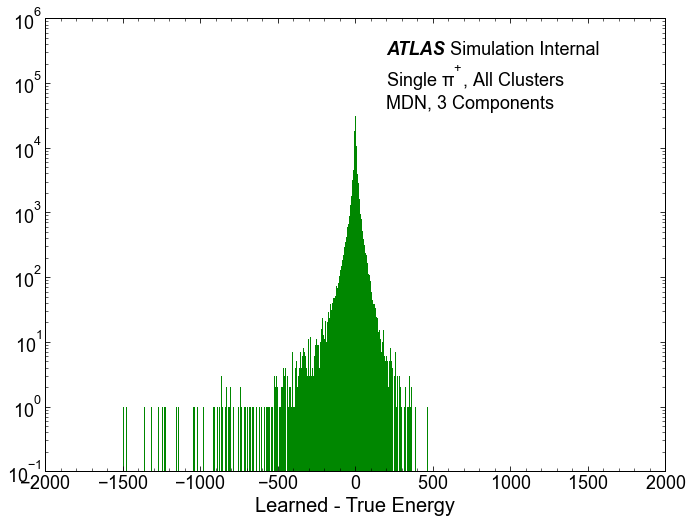

In [25]:
resid_MDN3 = pp.predict_regressor_MDN3-pp.cluster_ENG_CALIB_TOT
resid_MDN3_mask = np.logical_and(resid_MDN3 < 2000, resid_MDN3 > -2000)

n_bins = 500
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(resid_MDN3[resid_MDN3_mask],bins = n_bins)
plt.yscale('log')
plt.xlabel('Learned - True Energy')
plt.xlim(-2000,2000)
plt.legend()

atlas_x = 0.55
atlas_y = 0.95
simulation = True
textlist = [{'x': 0.55, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
            {'x': 0.55, 'y': 0.8,  'text': 'MDN, 3 Components'}]
pu.drawLabels(fig, atlas_x, atlas_y, simulation, textlist)

plt.show()

<Figure size 799.992x599.976 with 0 Axes>

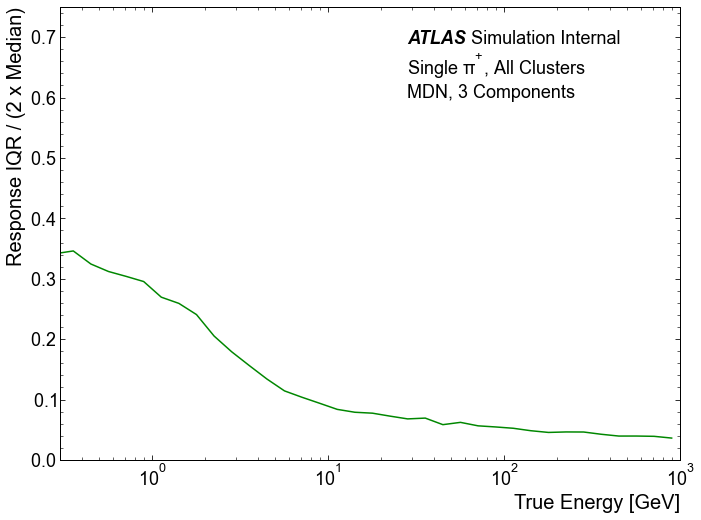

In [26]:
xcenter, iqrMDN3 = resolutionPlot(pp[pp.test].cluster_ENG_CALIB_TOT,
                        pp[pp.test].predict_regressor_MDN3_EoverCalib,
                        ylim=(0,0.75),
                        atlas_x = 0.56, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.56, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                    {'x': 0.56, 'y': 0.8,  'text': 'MDN, 3 Components'}])

<Figure size 799.992x599.976 with 0 Axes>

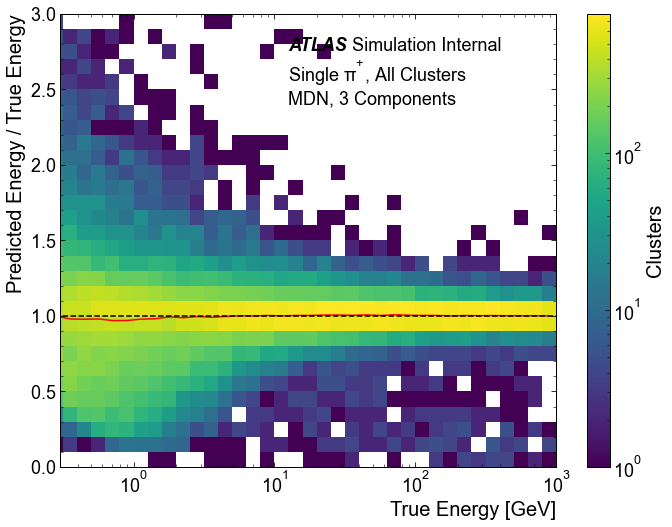

In [27]:
xcenter, medMDN3 = ru.responsePlot(pp[pp.test].cluster_ENG_CALIB_TOT, pp[pp.test].predict_regressor_MDN3_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_E1T0_pp_profile.pdf',
                 'median',
                 atlas_x = 0.46, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.46, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.46, 'y': 0.8,  'text': 'MDN, 3 Components'}])